<a href="https://colab.research.google.com/github/busrayildirim0/AI-Based-Cosmic-Rejection-Event-Classification-for-LArTPC-Detectors/blob/main/data_cleaning_and_model_checking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

cosmic_file_path = "/content/drive/MyDrive/signal-background-pilot-data/cosmic.csv"
neutrino_file_path = "/content/drive/MyDrive/signal-background-pilot-data/signal.csv"

def find_header_row(file_path, target_keyword="EventID"):

    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            for i, line in enumerate(f):
                if line.strip().startswith(target_keyword):
                    return i
        return 0
    except:
        return 0

def load_and_clean_robust(file_path, label, label_name):
    print(f"\n--- {label_name} Verisi")

    header_idx = find_header_row(file_path)
    print(f"   -> Başlık {header_idx}. satırda bulundu.")

    try:
        df = pd.read_csv(file_path, sep=';', header=header_idx, on_bad_lines='skip')

        df.columns = df.columns.str.strip()

        df = df[pd.to_numeric(df['EventID'], errors='coerce').notnull()]

        #  (nHits=0)
        initial_len = len(df)
        df['nHits'] = pd.to_numeric(df['nHits'], errors='coerce')
        df = df[df['nHits'] > 0]

        dropped = initial_len - len(df)
        if dropped > 0:
            print(f"   -> {dropped} adet boş olay (nHits=0) temizlendi.")

        df = df.dropna(axis=1, how='all')

        cols_to_convert = [col for col in df.columns if col not in ['InteractionType', 'EventType']]

        for col in cols_to_convert:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        df['Target'] = int(label)

        print(f" {label_name} Hazır! Temiz Boyut: {df.shape}")
        return df

    except Exception as e:
        print(f" HATA: {label_name} okunurken hata oluştu: {e}")
        return None


df_cosmic = load_and_clean_robust(cosmic_file_path, label=0, label_name="Kozmik (Background)")
df_neutrino = load_and_clean_robust(neutrino_file_path, label=1, label_name="Nötrino (Signal)")

if df_cosmic is not None and df_neutrino is not None:

    df_final = pd.concat([df_cosmic, df_neutrino], ignore_index=True)

    df_final = shuffle(df_final, random_state=42).reset_index(drop=True)

    print(" BİRLEŞTİRİLMİŞ TEMİZ VERİ")
    print(f"Toplam Veri Sayısı: {len(df_final)}")

    n_cosmic = len(df_final[df_final['Target']==0])
    n_neutrino = len(df_final[df_final['Target']==1])

    print(f"Kozmik Sayısı (0):  {n_cosmic}")
    print(f"Nötrino Sayısı (1): {n_neutrino}")

    if n_neutrino > 0:
        print(f"Mevcut Oran: 1 Sinyal'e karşı {n_cosmic/n_neutrino:.2f} Kozmik")
    else:
        print("Oran hesaplanamadı (Sinyal verisi yok).")

    # 5. Kaydet
    output_name = "/content/drive/MyDrive/signal-background-pilot-data/LArTPC_pilot_Cleaned.csv"
    df_final.to_csv(output_name, index=False)
    print(f"\n Dosya kaydedildi: {output_name}")

    print("\nÖrnek Veri (İlk 5 Satır):")
    print(df_final[['EventID', 'InteractionType', 'Target']].head())

else:
    print("\n Dosyalar okunamadı")


--- Kozmik (Background) Verisi
   -> Başlık 8. satırda bulundu.
   -> 64988 adet boş olay (nHits=0) temizlendi.
 Kozmik (Background) Hazır! Temiz Boyut: (35012, 43)

--- Nötrino (Signal) Verisi
   -> Başlık 8. satırda bulundu.
   -> 9219 adet boş olay (nHits=0) temizlendi.
 Nötrino (Signal) Hazır! Temiz Boyut: (90781, 43)
 BİRLEŞTİRİLMİŞ TEMİZ VERİ
Toplam Veri Sayısı: 125793
Kozmik Sayısı (0):  35012
Nötrino Sayısı (1): 90781
Mevcut Oran: 1 Sinyal'e karşı 0.39 Kozmik

 Dosya kaydedildi: /content/drive/MyDrive/signal-background-pilot-data/LArTPC_pilot_Cleaned.csv

Örnek Veri (İlk 5 Satır):
   EventID InteractionType  Target
0    66258            CCQE       1
1    33090            CCQE       1
2    55912          Cosmic       0
3    27515           CC1Pi       1
4    15320            CCQE       1



İstatistiksel Özet (Group by Target) 
Label                            Kozmik       Nötrino
vertex_y_cm        count   35012.000000  90781.000000
                   mean       -0.291697     -0.023583
                   std        97.622460     67.443169
                   min      -199.430692   -116.499572
                   5%       -116.500000   -105.103040
                   50%        -0.823505     -0.115747
                   95%       116.500000    104.859706
                   max       199.869139    116.498710
primary_py_GeV     count   35012.000000  90781.000000
                   mean       -0.005686      0.000251
                   std         1.320684      0.277137
                   min      -149.242627     -1.132438
                   5%         -0.858614     -0.490279
                   50%         0.003233      0.000000
                   95%         0.844687      0.489906
                   max        85.616588      1.113929
VisibleEnergy_MeV  count   35012.000000  90

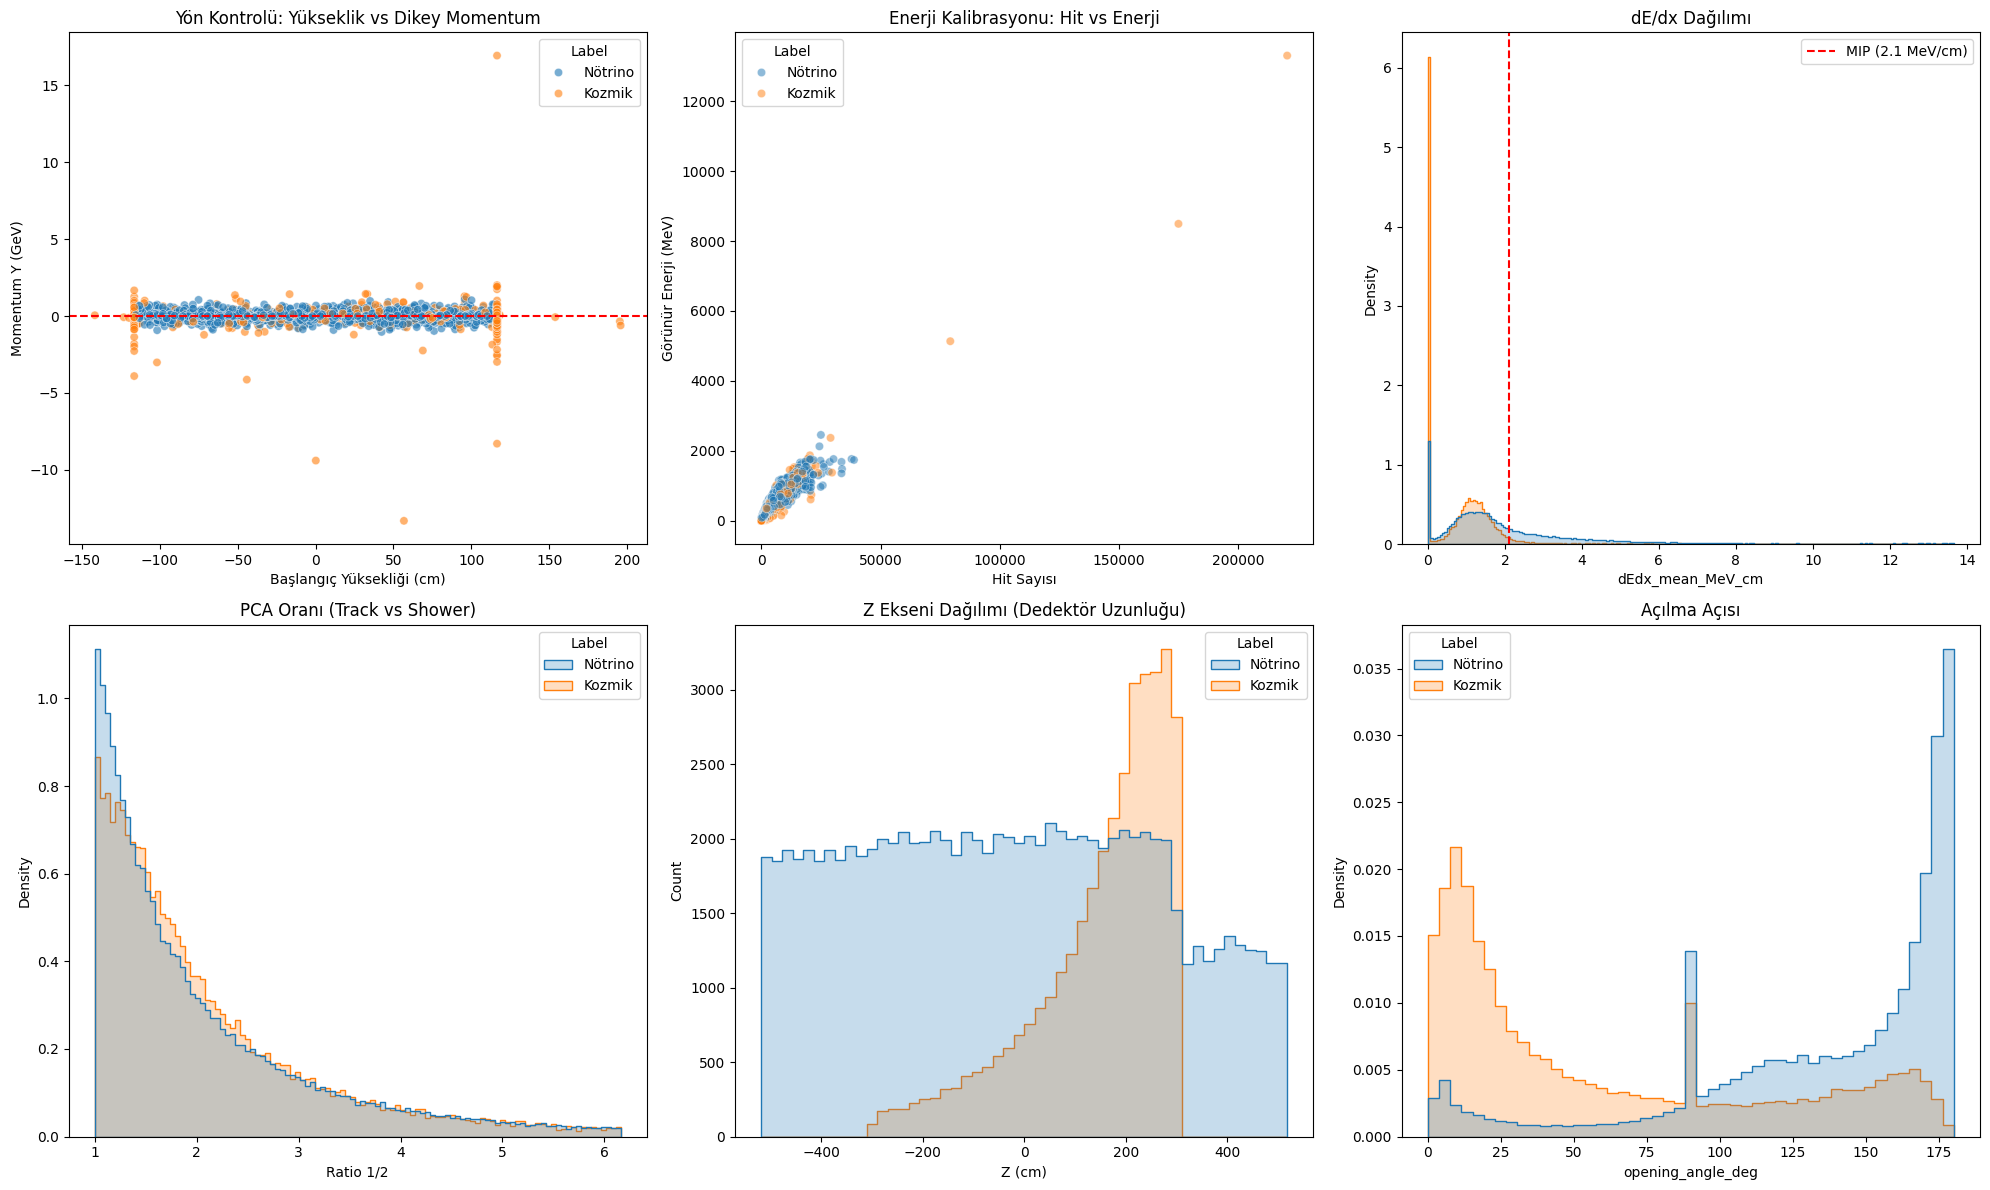


--- Anomali Raporu ---
Negatif Enerjili Olay Sayısı: 0
Aşırı Yüksek dE/dx (>50) Sayısı: 0
U Düzlemi Boş Olay Sayısı: 25346 (Bu normal olabilir)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "/content/drive/MyDrive/signal-background-pilot-data/LArTPC_pilot_Cleaned.csv"

df = pd.read_csv(file_path)

df['Label'] = df['Target'].map({0: 'Kozmik', 1: 'Nötrino'})

cols_to_check = [
    'vertex_y_cm', 'primary_py_GeV', 'VisibleEnergy_MeV',
    'nHits', 'dEdx_mean_MeV_cm', 'hit_time_spread_us', 'pca_ratio_12'
]

print("\nİstatistiksel Özet (Group by Target) ")
summary = df.groupby('Label')[cols_to_check].describe(percentiles=[0.05, 0.5, 0.95]).T
print(summary)

plt.figure(figsize=(20, 12))

plt.subplot(2, 3, 1)
sample = df.sample(n=min(2000, len(df)), random_state=42)
sns.scatterplot(data=sample, x='vertex_y_cm', y='primary_py_GeV', hue='Label', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Yön Kontrolü: Yükseklik vs Dikey Momentum")
plt.xlabel("Başlangıç Yüksekliği (cm)")
plt.ylabel("Momentum Y (GeV)")

plt.subplot(2, 3, 2)
sns.scatterplot(data=sample, x='nHits', y='VisibleEnergy_MeV', hue='Label', alpha=0.5)
plt.title("Enerji Kalibrasyonu: Hit vs Enerji")
plt.xlabel("Hit Sayısı")
plt.ylabel("Görünür Enerji (MeV)")

plt.subplot(2, 3, 3)
limit_dedx = np.percentile(df['dEdx_mean_MeV_cm'], 99)
sns.histplot(data=df[df['dEdx_mean_MeV_cm'] < limit_dedx],
             x='dEdx_mean_MeV_cm', hue='Label', element="step", stat="density", common_norm=False)
plt.axvline(2.1, color='red', linestyle='--', label='MIP (2.1 MeV/cm)')
plt.title("dE/dx Dağılımı")
plt.legend()

plt.subplot(2, 3, 4)
limit_pca = np.percentile(df['pca_ratio_12'], 95)
sns.histplot(data=df[df['pca_ratio_12'] < limit_pca],
             x='pca_ratio_12', hue='Label', element="step", stat="density", common_norm=False)
plt.title("PCA Oranı (Track vs Shower)")
plt.xlabel("Ratio 1/2")

plt.subplot(2, 3, 5)
sns.histplot(data=df, x='vertex_z_cm', hue='Label', element="step", bins=50)
plt.title("Z Ekseni Dağılımı (Dedektör Uzunluğu)")
plt.xlabel("Z (cm)")

plt.subplot(2, 3, 6)
sns.histplot(data=df, x='opening_angle_deg', hue='Label', element="step", stat="density", common_norm=False)
plt.title("Açılma Açısı")

plt.tight_layout()
plt.show()

print("\n--- Anomali Raporu ---")
neg_energy = (df['VisibleEnergy_MeV'] < 0).sum()
weird_dedx = (df['dEdx_mean_MeV_cm'] > 50).sum()
zeros_U_plane = (df['nHits_U'] == 0).sum()

print(f"Negatif Enerjili Olay Sayısı: {neg_energy}")
print(f"Aşırı Yüksek dE/dx (>50) Sayısı: {weird_dedx}")
print(f"U Düzlemi Boş Olay Sayısı: {zeros_U_plane} (Bu normal olabilir)")

In [ ]:
pip install tensorflow


Eğitimde Kullanılacak Özellik Sayısı: 33
Kullanılan Özellikler: ['vertex_x_cm', 'vertex_y_cm', 'vertex_z_cm', 'primary_px_GeV', 'primary_py_GeV', 'primary_pz_GeV', 'primary_theta_deg', 'primary_phi_deg', 'nHits', 'VisibleEnergy_MeV', 'AvgHitEnergy_MeV', 'hit_length_x_cm', 'hit_length_y_cm', 'hit_length_z_cm', 'hit_aspect_ratio', 'pca_eigenvalue_1', 'pca_eigenvalue_2', 'pca_eigenvalue_3', 'pca_ratio_12', 'pca_ratio_13', 'opening_angle_deg', 'track_angle_wrt_beam_deg', 'dEdx_mean_MeV_cm', 'dEdx_std_MeV_cm', 'energy_front_fraction', 'energy_back_fraction', 'hit_density_per_cm3', 'hit_time_spread_us', 'n_isolated_hits', 'nHits_U', 'nHits_V', 'nHits_Y', 'hit_plane_ratio_Y_UV']

 Sınıf Ağırlıkları (Modelin Dikkat Dengesi) 
Kozmik (0) Ağırlığı: 1.80
Nötrino (1) Ağırlığı: 0.69


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9087 - loss: 0.1927 - val_accuracy: 0.9968 - val_loss: 0.0128 - learning_rate: 0.0010
Epoch 2/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9923 - loss: 0.0244 - val_accuracy: 0.9980 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 3/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9955 - loss: 0.0149 - val_accuracy: 0.9982 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 4/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9967 - loss: 0.0092 - val_accuracy: 0.9985 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 5/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9974 - loss: 0.0077 - val_accuracy: 0.9990 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 6/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9978 - loss: 0.0071 - val_accuracy: 0.9990 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 7/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9981 - loss

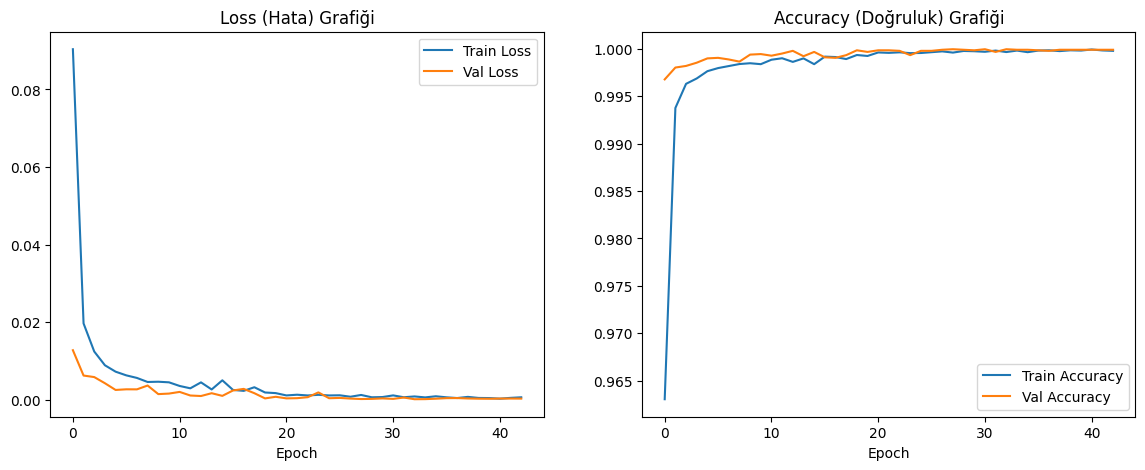

1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

-TEST SONUÇLARI 
              precision    recall  f1-score   support

  Kozmik (0)       1.00      1.00      1.00     10504
 Nötrino (1)       1.00      1.00      1.00     27234

    accuracy                           1.00     37738
   macro avg       1.00      1.00      1.00     37738
weighted avg       1.00      1.00      1.00     37738



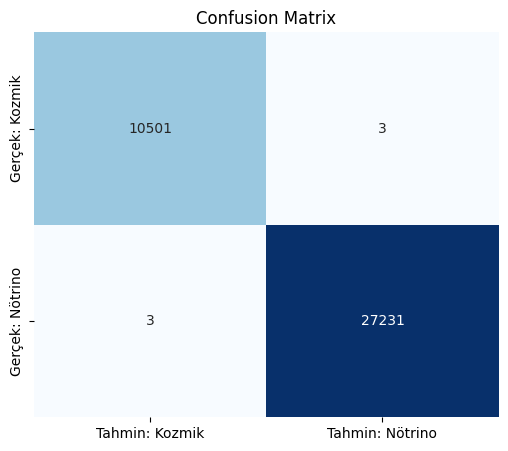

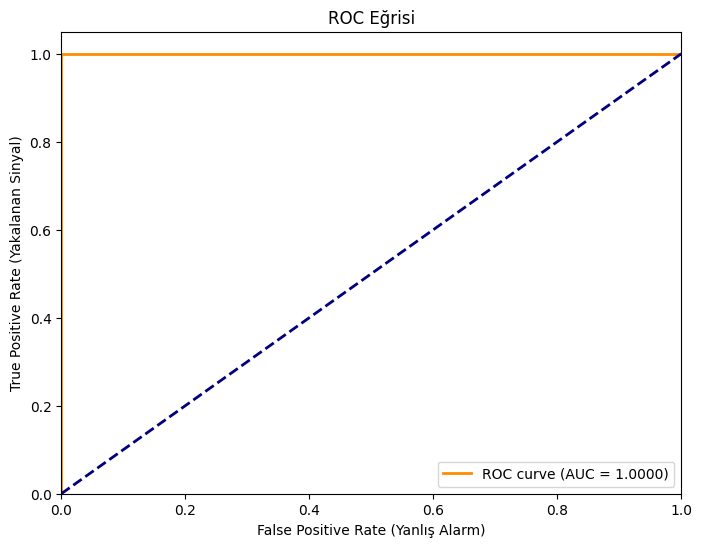

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

file_path = "/content/drive/MyDrive/signal-background-pilot-data/LArTPC_pilot_Cleaned.csv"
df = pd.read_csv(file_path)


drop_columns = [
    'EventID',
    'Target',
    'EventType',
    'InteractionType',
    'Enu_GeV',
    'Q2_GeV2', 'W_GeV',
    'primary_PDG',
    'primary_p_GeV',
    'primary_E_GeV'
]

existing_drop_cols = [col for col in drop_columns if col in df.columns]
X = df.drop(columns=existing_drop_cols)
y = df['Target']

print(f"\nEğitimde Kullanılacak Özellik Sayısı: {X.shape[1]}")
print("Kullanılan Özellikler:", list(X.columns))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {0: weights[0], 1: weights[1]}

print("\n Sınıf Ağırlıkları (Modelin Dikkat Dengesi) ")
print(f"Kozmik (0) Ağırlığı: {class_weights[0]:.2f}")
print(f"Nötrino (1) Ağırlığı: {class_weights[1]:.2f}")

model = Sequential()

model.add(Dense(256, input_shape=(X_train_scaled.shape[1],), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss (Hata) Grafiği')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy (Doğruluk) Grafiği')
plt.xlabel('Epoch')
plt.legend()
plt.show()

y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print("\n-TEST SONUÇLARI ")
print(classification_report(y_test, y_pred, target_names=['Kozmik (0)', 'Nötrino (1)']))

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Tahmin: Kozmik', 'Tahmin: Nötrino'],
            yticklabels=['Gerçek: Kozmik', 'Gerçek: Nötrino'])
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Yanlış Alarm)')
plt.ylabel('True Positive Rate (Yakalanan Sinyal)')
plt.title('ROC Eğrisi')
plt.legend(loc="lower right")
plt.show()

Feature Importance


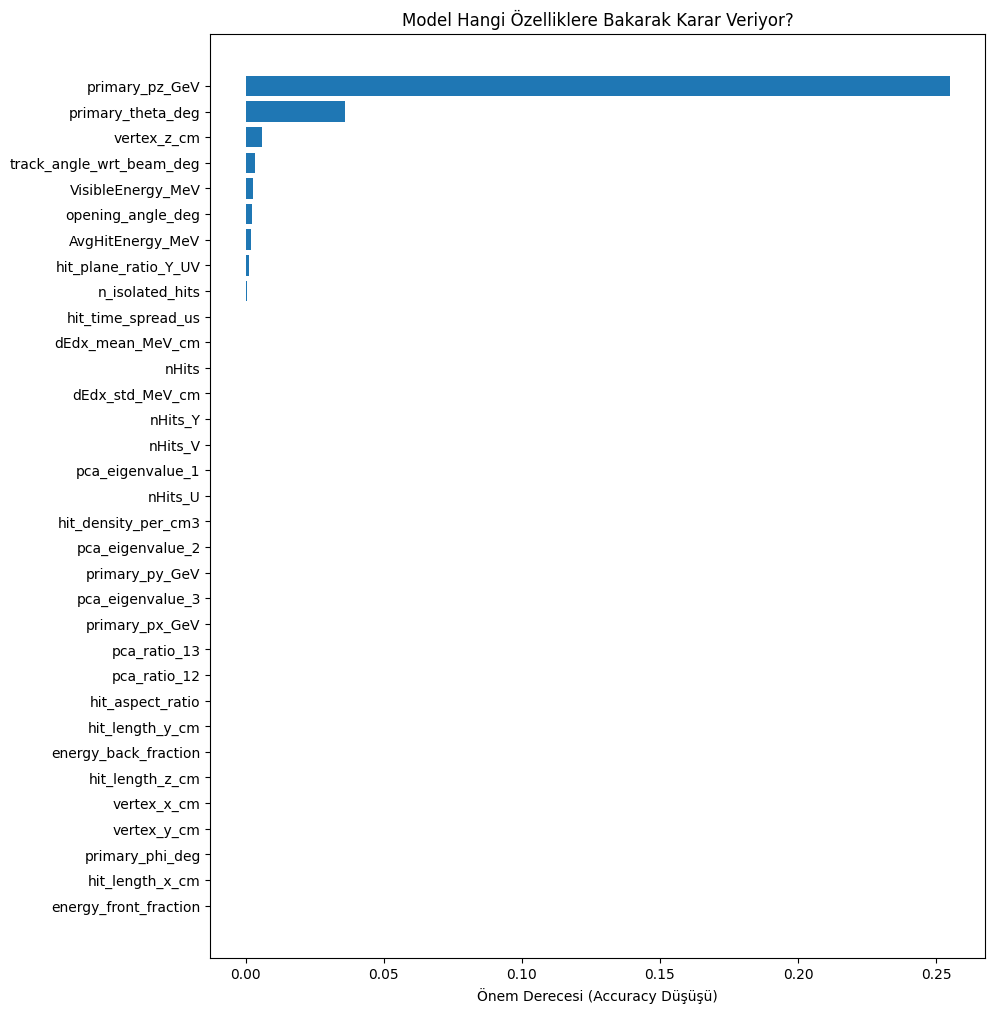

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class KerasClassifierWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        return self

    def predict(self, X):
        probs = self.model.predict(X, verbose=0)
        return (probs > 0.5).astype(int).flatten()

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

wrapped_model = KerasClassifierWrapper(model)

print("Feature Importance")

results = permutation_importance(wrapped_model, X_test_scaled, y_test,
                                 scoring='accuracy',
                                 n_repeats=5,
                                 random_state=42)

sorted_idx = results.importances_mean.argsort()

plt.figure(figsize=(10, 12))
plt.barh(X.columns[sorted_idx], results.importances_mean[sorted_idx])
plt.xlabel("Önem Derecesi (Accuracy Düşüşü)")
plt.title("Model Hangi Özelliklere Bakarak Karar Veriyor?")
plt.show()


Eğitimde Kullanılacak Özellik Sayısı: 24
Kullanılan Özellikler: ['nHits', 'VisibleEnergy_MeV', 'AvgHitEnergy_MeV', 'hit_length_x_cm', 'hit_length_y_cm', 'hit_length_z_cm', 'hit_aspect_ratio', 'pca_eigenvalue_1', 'pca_eigenvalue_2', 'pca_eigenvalue_3', 'pca_ratio_12', 'pca_ratio_13', 'opening_angle_deg', 'dEdx_mean_MeV_cm', 'dEdx_std_MeV_cm', 'energy_front_fraction', 'energy_back_fraction', 'hit_density_per_cm3', 'hit_time_spread_us', 'n_isolated_hits', 'nHits_U', 'nHits_V', 'nHits_Y', 'hit_plane_ratio_Y_UV']

 Sınıf Ağırlıkları (Modelin Dikkat Dengesi) 
Kozmik (0) Ağırlığı: 1.80
Nötrino (1) Ağırlığı: 0.69


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8585 - loss: 0.3156 - val_accuracy: 0.9424 - val_loss: 0.1760 - learning_rate: 0.0010
Epoch 2/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9251 - loss: 0.1988 - val_accuracy: 0.9453 - val_loss: 0.1520 - learning_rate: 0.0010
Epoch 3/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9313 - loss: 0.1831 - val_accuracy: 0.9442 - val_loss: 0.1516 - learning_rate: 0.0010
Epoch 4/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9337 - loss: 0.1721 - val_accuracy: 0.9466 - val_loss: 0.1404 - learning_rate: 0.0010
Epoch 5/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9385 - loss: 0.1641 - val_accuracy: 0.9428 - val_loss: 0.1494 - learning_rate: 0.0010
Epoch 6/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9387 - loss: 0.1623 - val_accuracy: 0.9463 - val_loss: 0.1412 - learning_rate: 0.0010
Epoch 7/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9444 - loss:

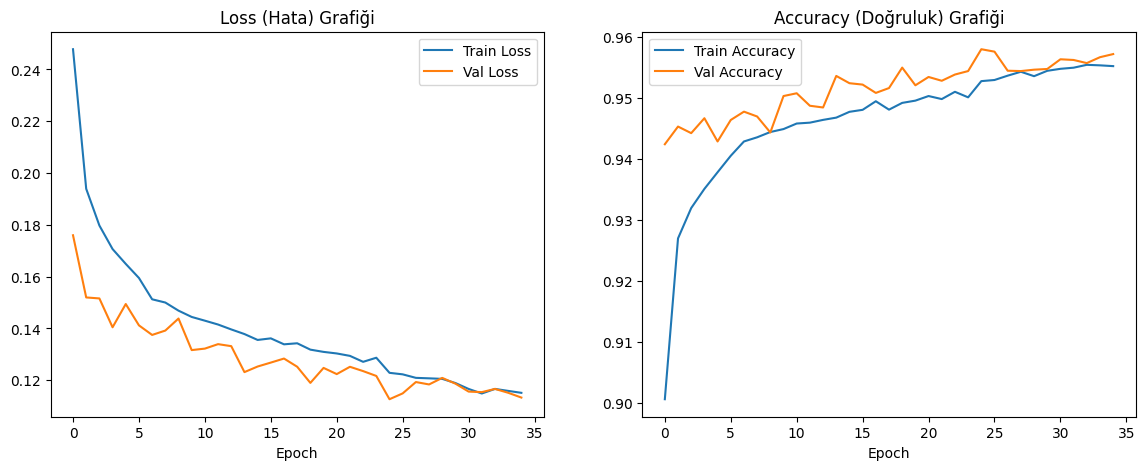

1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

-TEST SONUÇLARI 
              precision    recall  f1-score   support

  Kozmik (0)       0.89      0.95      0.92     10504
 Nötrino (1)       0.98      0.96      0.97     27234

    accuracy                           0.96     37738
   macro avg       0.94      0.95      0.95     37738
weighted avg       0.96      0.96      0.96     37738



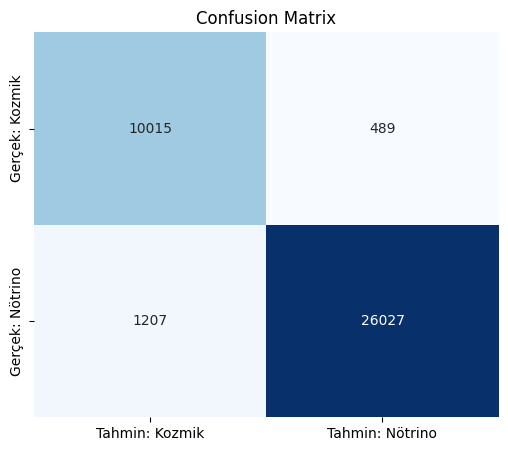

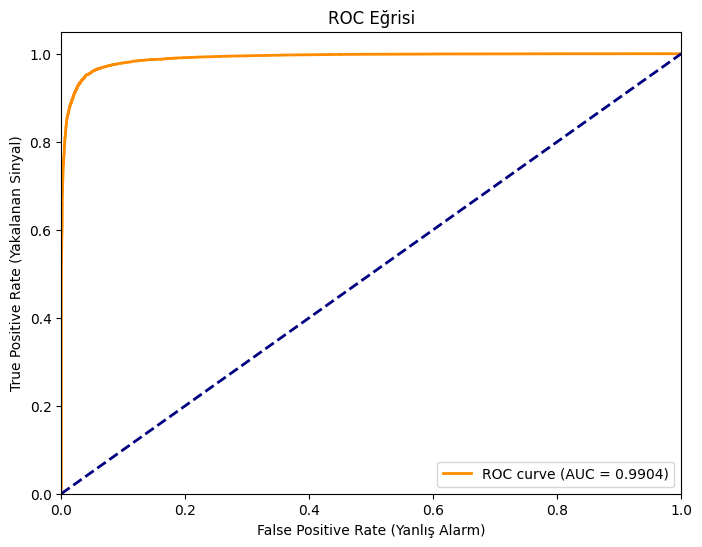

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

file_path = "/content/drive/MyDrive/signal-background-pilot-data/LArTPC_pilot_Cleaned.csv"
df = pd.read_csv(file_path)


drop_columns = [
    'EventID',
    'Target',
    'EventType',
    'InteractionType',

    'Enu_GeV',
    'Q2_GeV2', 'W_GeV',
    'primary_PDG',
    'primary_p_GeV',
    'primary_E_GeV',

    'primary_px_GeV',
    'primary_py_GeV',
    'primary_pz_GeV',
    'primary_theta_deg',
    'primary_phi_deg',
    'vertex_x_cm',
    'vertex_y_cm',
    'vertex_z_cm',
    'track_angle_wrt_beam_deg'
]

existing_drop_cols = [col for col in drop_columns if col in df.columns]
X = df.drop(columns=existing_drop_cols)
y = df['Target']

print(f"\nEğitimde Kullanılacak Özellik Sayısı: {X.shape[1]}")
print("Kullanılan Özellikler:", list(X.columns))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {0: weights[0], 1: weights[1]}

print("\n Sınıf Ağırlıkları (Modelin Dikkat Dengesi) ")
print(f"Kozmik (0) Ağırlığı: {class_weights[0]:.2f}")
print(f"Nötrino (1) Ağırlığı: {class_weights[1]:.2f}")

model = Sequential()

model.add(Dense(256, input_shape=(X_train_scaled.shape[1],), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss (Hata) Grafiği')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy (Doğruluk) Grafiği')
plt.xlabel('Epoch')
plt.legend()
plt.show()

y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print("\n-TEST SONUÇLARI ")
print(classification_report(y_test, y_pred, target_names=['Kozmik (0)', 'Nötrino (1)']))

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Tahmin: Kozmik', 'Tahmin: Nötrino'],
            yticklabels=['Gerçek: Kozmik', 'Gerçek: Nötrino'])
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Yanlış Alarm)')
plt.ylabel('True Positive Rate (Yakalanan Sinyal)')
plt.title('ROC Eğrisi')
plt.legend(loc="lower right")
plt.show()

--- 1. Korelasyon Analizi (Birbiriyle Aynı Olanlar) ---


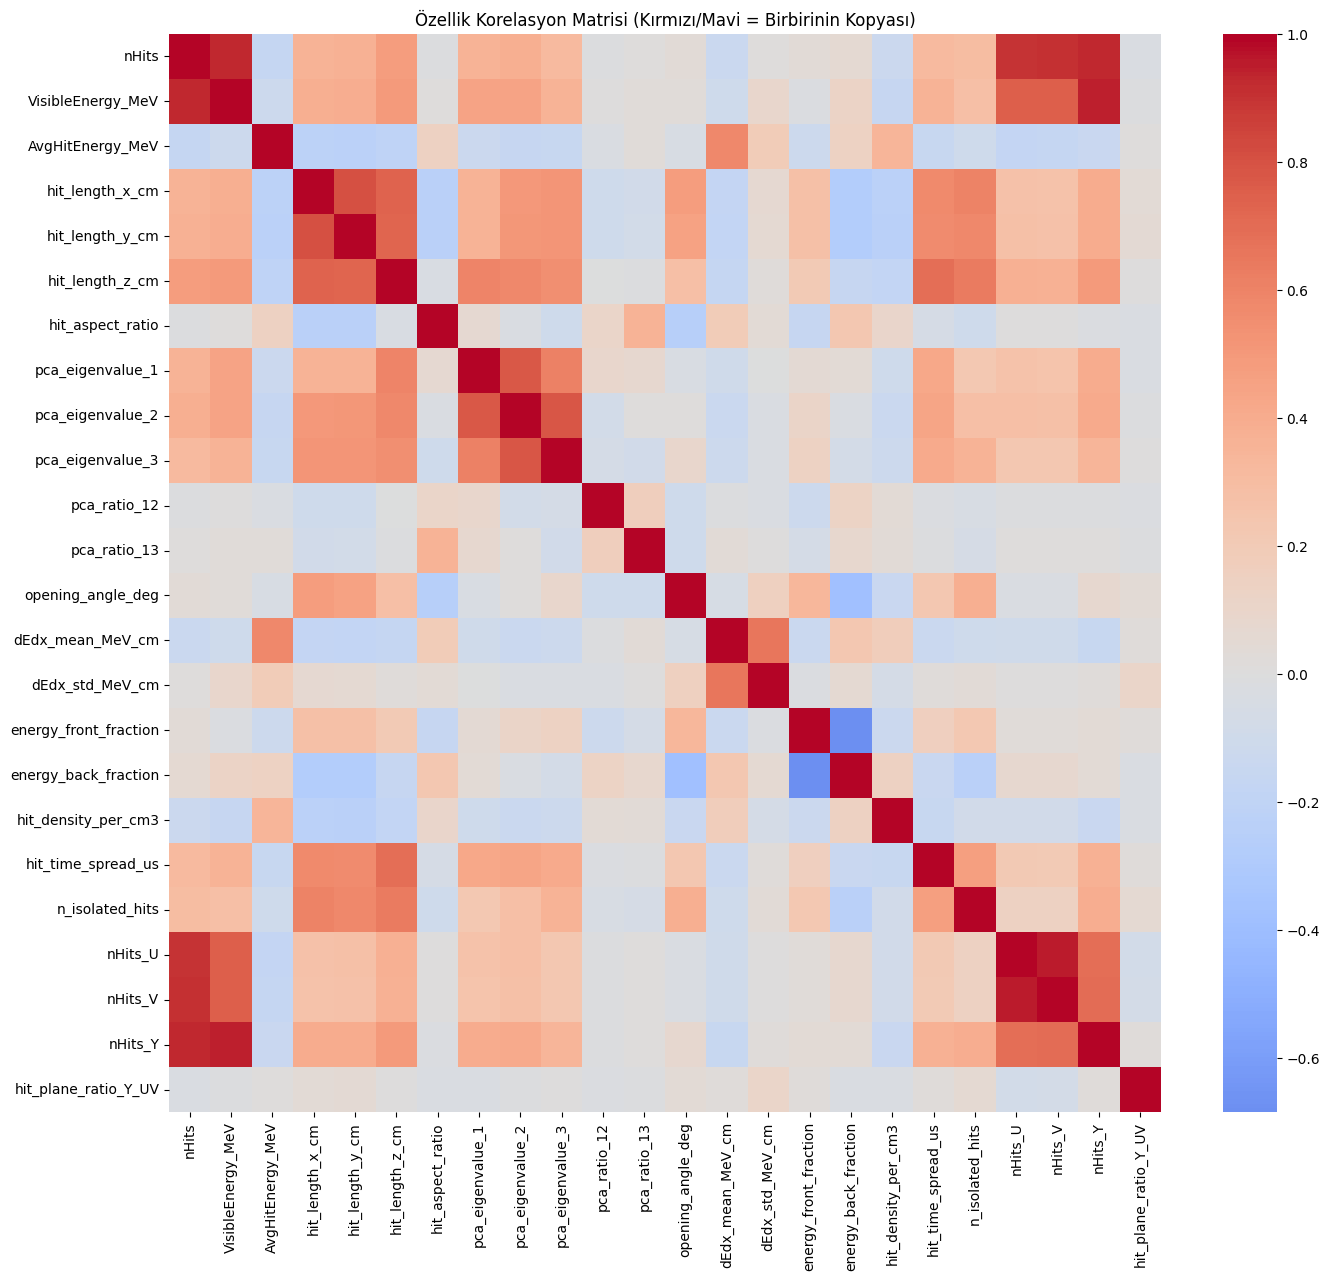


 Yüksek Korelasyonlu (Gereksiz Tekrar Eden) Çiftler:
nHits_V  nHits_U    0.954361
nHits_U  nHits_V    0.954361
dtype: float64

--- 2. Feature Importance (Permutation) ---


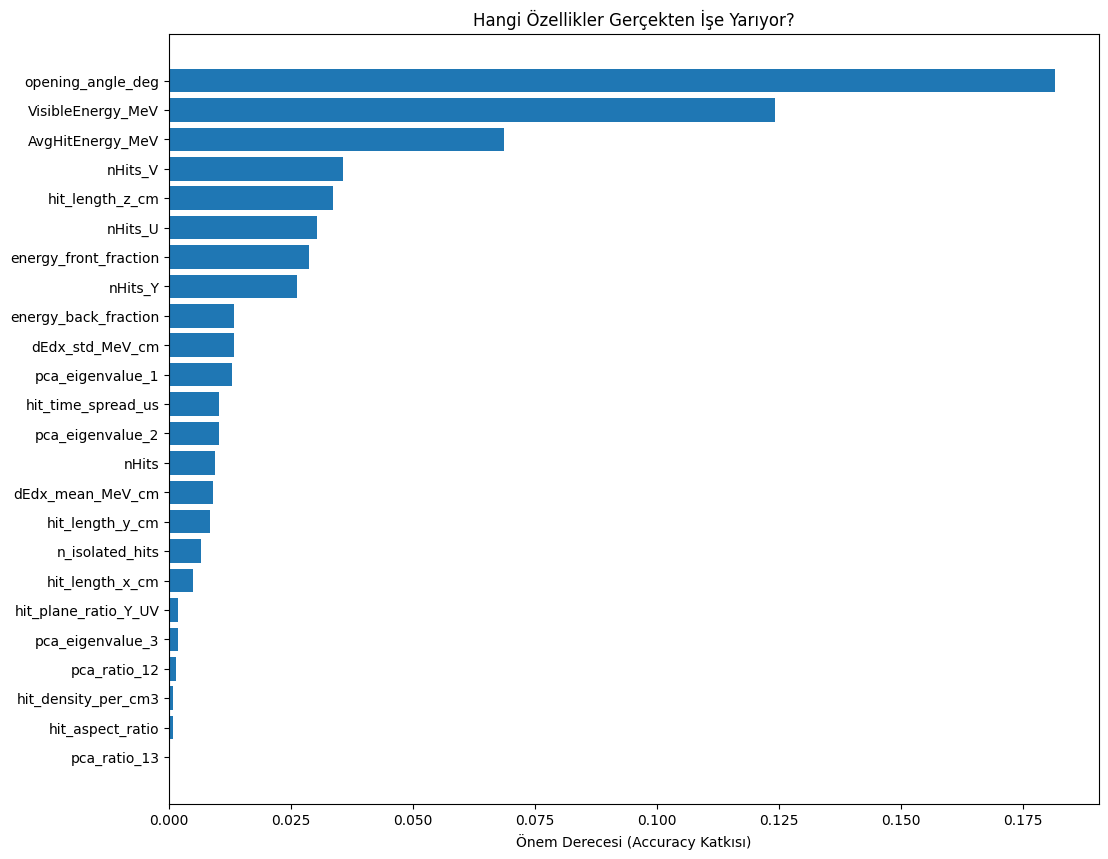


🗑️ Atılabilecek Adaylar (Etkisi Çok Düşük Olanlar):
- pca_ratio_13: 0.00010
- hit_aspect_ratio: 0.00072
- hit_density_per_cm3: 0.00080


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

file_path = "/content/drive/MyDrive/signal-background-pilot-data/LArTPC_pilot_Cleaned.csv"
df = pd.read_csv(file_path)

drop_columns = [
    'EventID', 'Target', 'EventType', 'InteractionType',
    'Enu_GeV', 'Q2_GeV2', 'W_GeV', 'primary_PDG',
    'primary_p_GeV', 'primary_E_GeV',
    'primary_px_GeV', 'primary_py_GeV', 'primary_pz_GeV',
    'primary_theta_deg', 'primary_phi_deg',
    'vertex_x_cm', 'vertex_y_cm', 'vertex_z_cm',
    'track_angle_wrt_beam_deg'
]

existing_drop_cols = [col for col in drop_columns if col in df.columns]
X = df.drop(columns=existing_drop_cols)
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("--- 1. Korelasyon Analizi (Birbiriyle Aynı Olanlar) ---")
plt.figure(figsize=(16, 14))
# Sadece özelliklerin birbirleriyle ilişkisi
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Özellik Korelasyon Matrisi (Kırmızı/Mavi = Birbirinin Kopyası)")
plt.show()

print("\n Yüksek Korelasyonlu (Gereksiz Tekrar Eden) Çiftler:")
corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)
high_corr = corr_pairs[(corr_pairs > 0.95) & (corr_pairs < 1.0)]
print(high_corr)



class KerasClassifierWrapper:
    def __init__(self, model):
        self.model = model
    def fit(self, X, y): return self
    def predict(self, X):
        probs = self.model.predict(X, verbose=0)
        return (probs > 0.5).astype(int).flatten()
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

if 'model' in locals():
    print("\n--- 2. Feature Importance (Permutation) ---")
    wrapped_model = KerasClassifierWrapper(model)

    results = permutation_importance(wrapped_model, X_test_scaled, y_test,
                                     scoring='accuracy', n_repeats=5, random_state=42)

    sorted_idx = results.importances_mean.argsort()

    plt.figure(figsize=(12, 10))
    plt.barh(X.columns[sorted_idx], results.importances_mean[sorted_idx])
    plt.xlabel("Önem Derecesi (Accuracy Katkısı)")
    plt.title("Hangi Özellikler Gerçekten İşe Yarıyor?")
    plt.show()

    print("\n🗑️ Atılabilecek Adaylar (Etkisi Çok Düşük Olanlar):")
    for i in sorted_idx:
        if results.importances_mean[i] < 0.001: # Eşik değeri
            print(f"- {X.columns[i]}: {results.importances_mean[i]:.5f}")

else:
    print("HATA: 'model' nesnesi bulunamadı. Lütfen önce eğitim kodunu çalıştırın.")

In [ ]:
# --- FİNAL GÜVENLİ ÖZELLİK LİSTESİ ---
# 24 özellikten en etkili 14 tanesine düşürüldü.

final_features = [
    # 1. Topolojik (Şekil) Özellikler
    'opening_angle_deg',       # Kozmik (Düz) vs Nötrino (Saçılma)
    'hit_length_z_cm',         # Dedektör boyunca ne kadar gitti?
    'hit_length_y_cm',         # Yüksekliği ne kadar? (Kozmik yukarıdan gelir)

    #2. Kalorimetrik (Enerji) Özellikler
    'VisibleEnergy_MeV',       # Toplam Enerji (nHits yerine bunu seçtik)
    'AvgHitEnergy_MeV',        # Hit başına düşen enerji (Parlaklık)
    'dEdx_mean_MeV_cm',        # PARÇACIK KİMLİĞİ (Proton vs Müon ayrımı)
    'dEdx_std_MeV_cm',         # dE/dx dalgalanması

    # 3. İz Yapısı ve Yönelim
    'energy_front_fraction',   # İzin başında enerji yoğunluğu (Bragg Peak yönü)
    'energy_back_fraction',    # İzin sonunda enerji yoğunluğu

    #4. PCA (Ana Bileşenler)
    'pca_eigenvalue_1',        # İzin ana uzunluğu
    'pca_eigenvalue_2',        # İzin genişliği (Shower vs Track)
    # Ratio'ları attık, ham değerler yeterli.

    # 5. Tel Düzlemleri (Wire Planes)
    'nHits_V',                 # Induction (En ayırt edici çıkmış)
    'nHits_Y',                 # Collection (En temiz sinyal)
    'hit_plane_ratio_Y_UV'     # Düzlemler arası oran (3D tutarlılık)
]

print(f"Optimize Edilmiş Özellik Sayısı: {len(final_features)}")

Optimize Edilmiş Özellik Sayısı: 14



Eğitimde Kullanılacak Özellik Sayısı: 14
Kullanılan Özellikler: ['opening_angle_deg', 'hit_length_z_cm', 'hit_length_y_cm', 'VisibleEnergy_MeV', 'AvgHitEnergy_MeV', 'dEdx_mean_MeV_cm', 'dEdx_std_MeV_cm', 'energy_front_fraction', 'energy_back_fraction', 'pca_eigenvalue_1', 'pca_eigenvalue_2', 'nHits_V', 'nHits_Y', 'hit_plane_ratio_Y_UV']

 Sınıf Ağırlıkları (Modelin Dikkat Dengesi) 
Kozmik (0) Ağırlığı: 1.80
Nötrino (1) Ağırlığı: 0.69


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.8670 - loss: 0.3041 - val_accuracy: 0.9394 - val_loss: 0.1881 - learning_rate: 0.0010
Epoch 2/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9258 - loss: 0.2013 - val_accuracy: 0.9419 - val_loss: 0.1583 - learning_rate: 0.0010
Epoch 3/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9311 - loss: 0.1833 - val_accuracy: 0.9404 - val_loss: 0.1588 - learning_rate: 0.0010
Epoch 4/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9328 - loss: 0.1793 - val_accuracy: 0.9458 - val_loss: 0.1471 - learning_rate: 0.0010
Epoch 5/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9355 - loss: 0.1722 - val_accuracy: 0.9425 - val_loss: 0.1512 - learning_rate: 0.0010
Epoch 6/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9357 - loss: 0.1647 - val_accuracy: 0.9453 - val_loss: 0.1429 - learning_rate: 0.0010
Epoch 7/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9387 - l

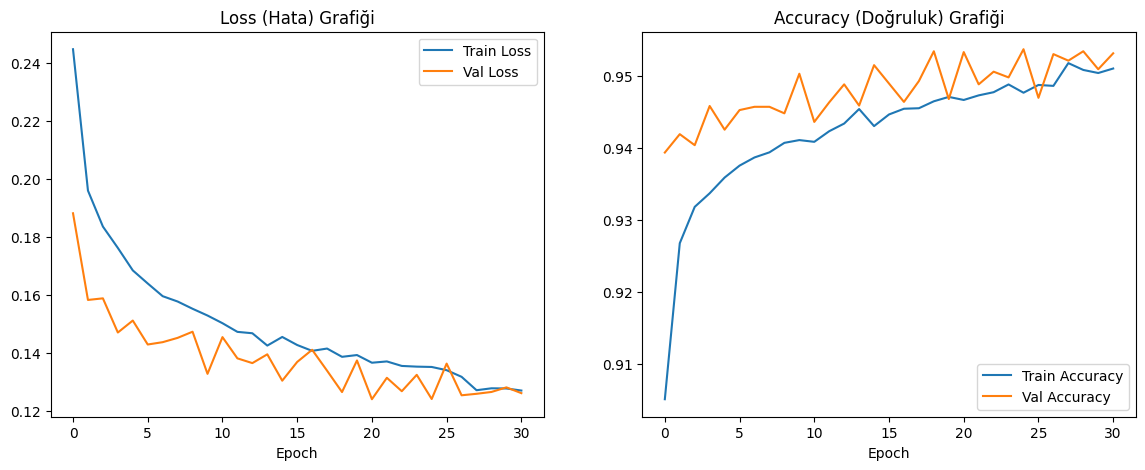

1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

-TEST SONUÇLARI 
              precision    recall  f1-score   support

  Kozmik (0)       0.89      0.95      0.92     10504
 Nötrino (1)       0.98      0.95      0.97     27234

    accuracy                           0.95     37738
   macro avg       0.93      0.95      0.94     37738
weighted avg       0.95      0.95      0.95     37738



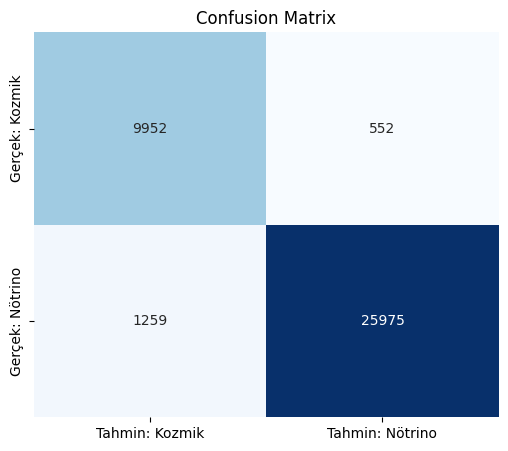

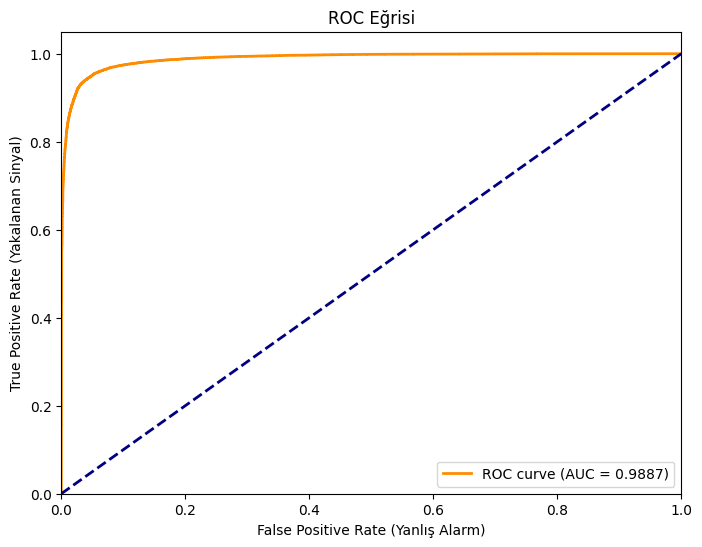

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

file_path = "/content/drive/MyDrive/signal-background-pilot-data/LArTPC_pilot_Cleaned.csv"
df = pd.read_csv(file_path)


final_features = [
    'opening_angle_deg',       # Kozmik (Düz) vs Nötrino (Saçılma)
    'hit_length_z_cm',         # Dedektör boyunca ne kadar gitti?
    'hit_length_y_cm',         # Yüksekliği ne kadar? (Kozmik yukarıdan gelir)
    'VisibleEnergy_MeV',       # Toplam Enerji (nHits yerine bunu seçtik)
    'AvgHitEnergy_MeV',        # Hit başına düşen enerji (Parlaklık)
    'dEdx_mean_MeV_cm',        # PARÇACIK KİMLİĞİ (Proton vs Müon ayrımı)
    'dEdx_std_MeV_cm',         # dE/dx dalgalanması
    'energy_front_fraction',   # İzin başında enerji yoğunluğu (Bragg Peak yönü)
    'energy_back_fraction',    # İzin sonunda enerji yoğunluğu
    'pca_eigenvalue_1',        # İzin ana uzunluğu
    'pca_eigenvalue_2',        # İzin genişliği (Shower vs Track)
    'nHits_V',                 # Induction (En ayırt edici çıkmış)
    'nHits_Y',                 # Collection (En temiz sinyal)
    'hit_plane_ratio_Y_UV'     # Düzlemler arası oran (3D tutarlılık)
]

X = df[final_features]
y = df['Target']

print(f"\nEğitimde Kullanılacak Özellik Sayısı: {X.shape[1]}")
print("Kullanılan Özellikler:", list(X.columns))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {0: weights[0], 1: weights[1]}

print("\n Sınıf Ağırlıkları (Modelin Dikkat Dengesi) ")
print(f"Kozmik (0) Ağırlığı: {class_weights[0]:.2f}")
print(f"Nötrino (1) Ağırlığı: {class_weights[1]:.2f}")

model = Sequential()

model.add(Dense(256, input_shape=(X_train_scaled.shape[1],), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss (Hata) Grafiği')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy (Doğruluk) Grafiği')
plt.xlabel('Epoch')
plt.legend()
plt.show()

y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print("\n-TEST SONUÇLARI ")
print(classification_report(y_test, y_pred, target_names=['Kozmik (0)', 'Nötrino (1)']))

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Tahmin: Kozmik', 'Tahmin: Nötrino'],
            yticklabels=['Gerçek: Kozmik', 'Gerçek: Nötrino'])
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Yanlış Alarm)')
plt.ylabel('True Positive Rate (Yakalanan Sinyal)')
plt.title('ROC Eğrisi')
plt.legend(loc="lower right")
plt.show()

--- 1. Final Liste Korelasyon Analizi ---


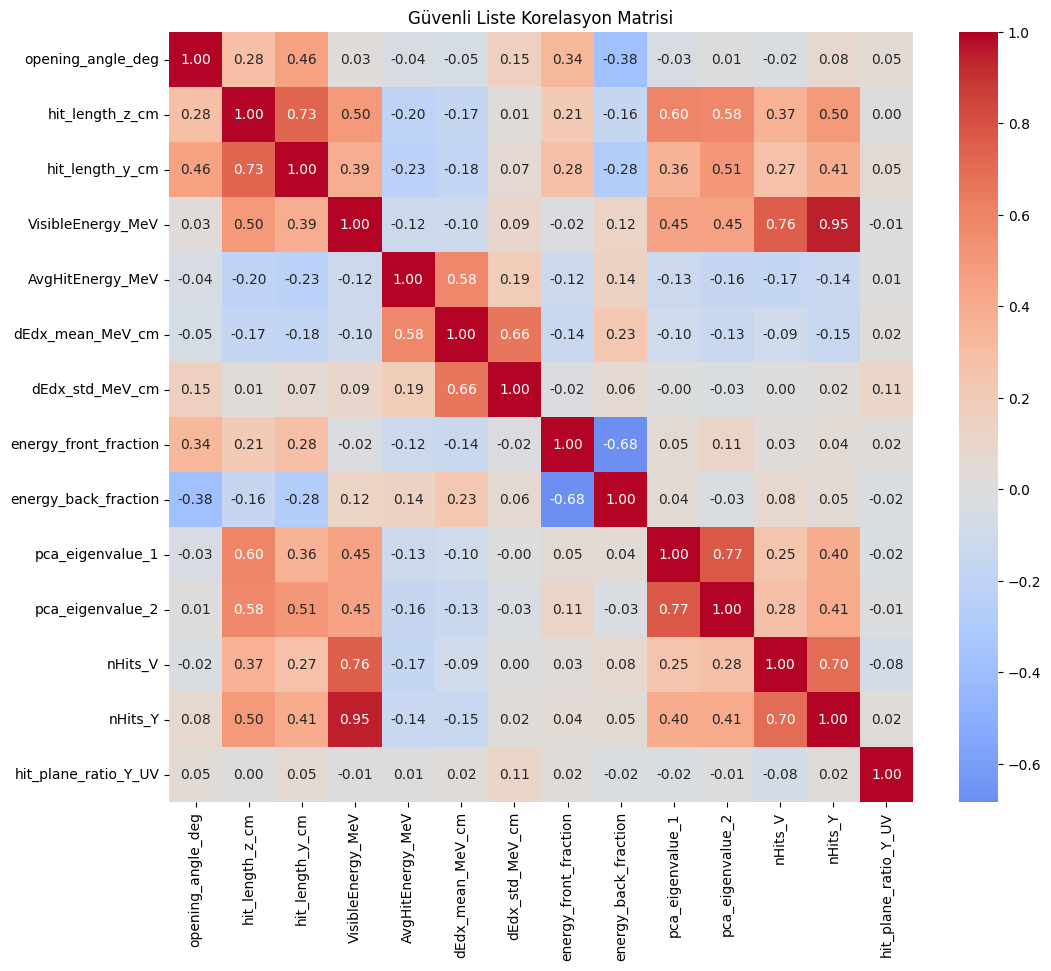


--- 2. Feature Importance (Hangi Özellikler Kaldı?) ---


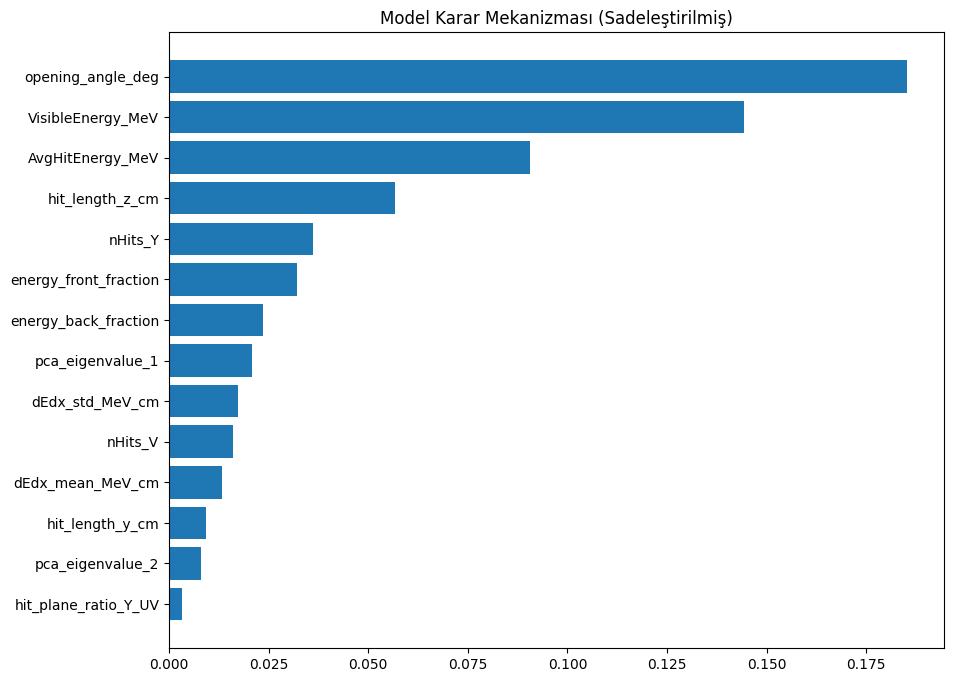

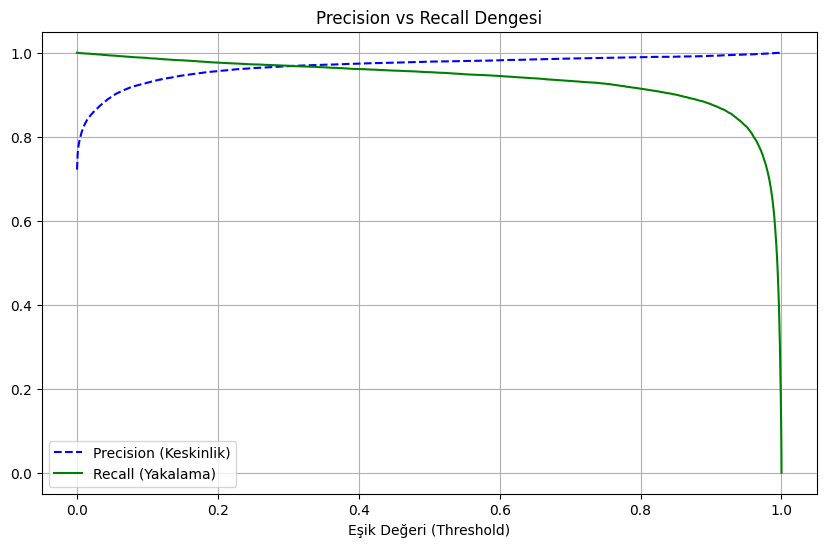


 ÖNERİLEN EŞİK DEĞERİ: 0.3042
Bu eşikte beklenen Precision: 0.9685
Bu eşikte beklenen Recall: 0.9686


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

file_path = "/content/drive/MyDrive/signal-background-pilot-data/LArTPC_pilot_Cleaned.csv"
df = pd.read_csv(file_path)

final_features = [
    'opening_angle_deg', 'hit_length_z_cm', 'hit_length_y_cm',
    'VisibleEnergy_MeV', 'AvgHitEnergy_MeV',
    'dEdx_mean_MeV_cm', 'dEdx_std_MeV_cm',
    'energy_front_fraction', 'energy_back_fraction',
    'pca_eigenvalue_1', 'pca_eigenvalue_2',
    'nHits_V', 'nHits_Y', 'hit_plane_ratio_Y_UV'
]

X = df[final_features]
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("--- 1. Final Liste Korelasyon Analizi ---")
plt.figure(figsize=(12, 10))
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Güvenli Liste Korelasyon Matrisi")
plt.show()

if 'model' in locals():
    print("\n--- 2. Feature Importance (Hangi Özellikler Kaldı?) ---")

    class KerasClassifierWrapper:
        def __init__(self, model):
            self.model = model
        def fit(self, X, y): return self
        def predict(self, X):
            probs = self.model.predict(X, verbose=0)
            return (probs > 0.5).astype(int).flatten()
        def score(self, X, y):
            return accuracy_score(y, self.predict(X))

    wrapped_model = KerasClassifierWrapper(model)
    results = permutation_importance(wrapped_model, X_test_scaled, y_test,
                                     scoring='accuracy', n_repeats=5, random_state=42)

    sorted_idx = results.importances_mean.argsort()

    plt.figure(figsize=(10, 8))
    plt.barh(X.columns[sorted_idx], results.importances_mean[sorted_idx])
    plt.title("Model Karar Mekanizması (Sadeleştirilmiş)")
    plt.show()

y_scores = model.predict(X_test_scaled, verbose=0)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision (Keskinlik)")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall (Yakalama)")
plt.xlabel("Eşik Değeri (Threshold)")
plt.legend(loc="best")
plt.title("Precision vs Recall Dengesi")
plt.grid(True)
plt.show()

f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = np.argmax(f1_scores)
print(f"\n ÖNERİLEN EŞİK DEĞERİ: {thresholds[best_idx]:.4f}")
print(f"Bu eşikte beklenen Precision: {precisions[best_idx]:.4f}")
print(f"Bu eşikte beklenen Recall: {recalls[best_idx]:.4f}")


Eğitimde Kullanılacak Özellik Sayısı: 12
Kullanılan Özellikler: ['opening_angle_deg', 'hit_length_z_cm', 'hit_length_y_cm', 'VisibleEnergy_MeV', 'AvgHitEnergy_MeV', 'dEdx_mean_MeV_cm', 'dEdx_std_MeV_cm', 'energy_front_fraction', 'energy_back_fraction', 'pca_eigenvalue_1', 'pca_eigenvalue_2', 'nHits_V']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/120
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.8051 - loss: 0.4022 - val_accuracy: 0.9234 - val_loss: 0.2823 - learning_rate: 5.0000e-04
Epoch 2/120
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9183 - loss: 0.2257 - val_accuracy: 0.9374 - val_loss: 0.1966 - learning_rate: 5.0000e-04
Epoch 3/120
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9225 - loss: 0.2101 - val_accuracy: 0.9412 - val_loss: 0.1714 - learning_rate: 5.0000e-04
Epoch 4/120
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9292 - loss: 0.1947 - val_accuracy: 0.9381 - val_loss: 0.1713 - learning_rate: 5.0000e-04
Epoch 5/120
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9294 - loss: 0.1915 - val_accuracy: 0.9421 - val_loss: 0.1631 - learning_rate: 5.0000e-04
Epoch 6/120
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9307 - loss: 0.1875 - val_accuracy: 0.9424 - val_loss: 0.1606 - learning_rate: 5.0000e-04
Epoch 7/120
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/st

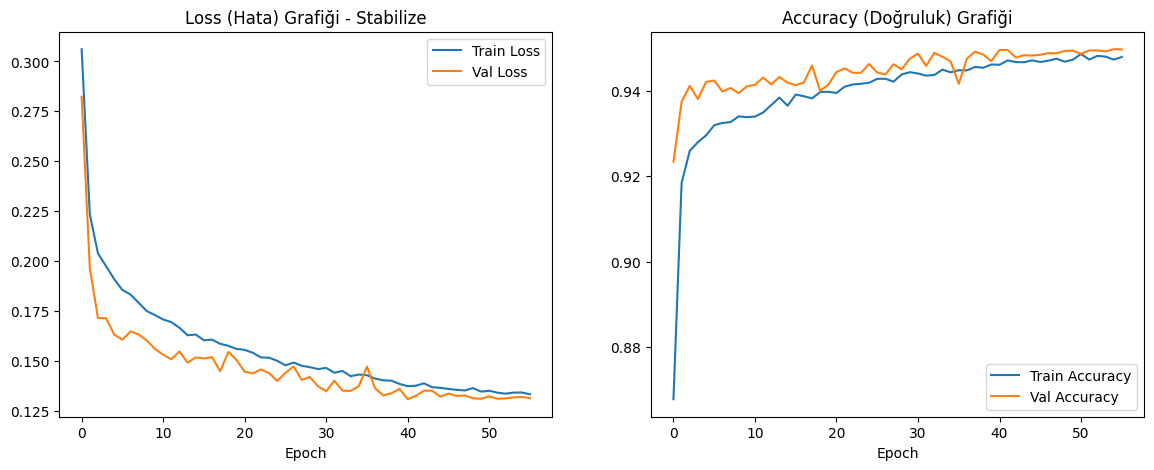

1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

--- TEST SONUÇLARI (Eşik Değeri: 0.3) ---
              precision    recall  f1-score   support

  Kozmik (0)       0.91      0.92      0.92     10504
 Nötrino (1)       0.97      0.97      0.97     27234

    accuracy                           0.95     37738
   macro avg       0.94      0.94      0.94     37738
weighted avg       0.95      0.95      0.95     37738



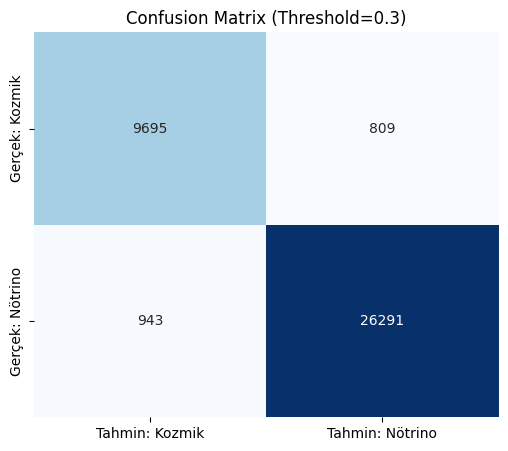

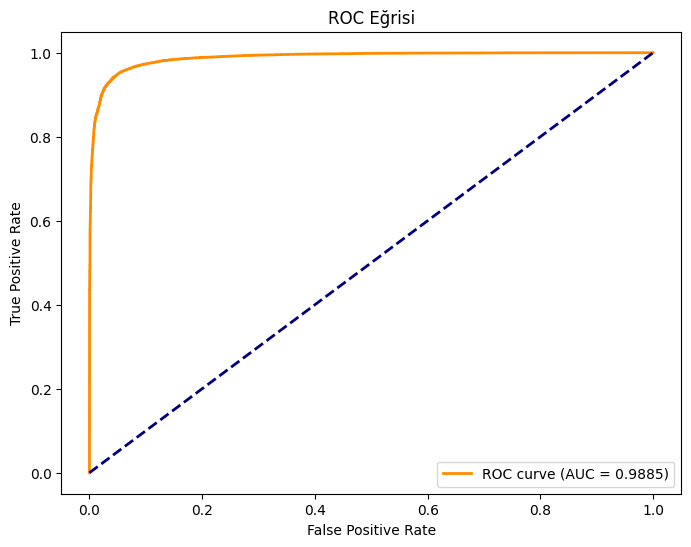

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

file_path = "/content/drive/MyDrive/signal-background-pilot-data/LArTPC_pilot_Cleaned.csv"
df = pd.read_csv(file_path)

#  FINAL ÖZELLİK LİSTESİ (14'ten 12'ye Düştü)
# Çıkarılanlar: nHits_Y (Kopya), hit_plane_ratio_Y_UV (Etkisiz)
final_features = [
    'opening_angle_deg',       # Topoloji: En Kritik
    'hit_length_z_cm',         # Geometri: Uzunluk
    'hit_length_y_cm',         # Geometri: Yükseklik
    'VisibleEnergy_MeV',       # Kalorimetri: Toplam Enerji
    'AvgHitEnergy_MeV',        # Kalorimetri: Parlaklık
    'dEdx_mean_MeV_cm',        # PID: Parçacık Kimliği
    'dEdx_std_MeV_cm',         # PID: Dalgalanma
    'energy_front_fraction',   # Yapı: Başlangıç yoğunluğu
    'energy_back_fraction',    # Yapı: Bitiş yoğunluğu
    'pca_eigenvalue_1',        # Şekil: Ana uzunluk
    'pca_eigenvalue_2',        # Şekil: Genişlik
    'nHits_V'                  # Induction Plane (Yedek teyit)
]

X = df[final_features]
y = df['Target']

print(f"\nEğitimde Kullanılacak Özellik Sayısı: {X.shape[1]}")
print("Kullanılan Özellikler:", list(X.columns))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {0: weights[0], 1: weights[1]}

model = Sequential()

model.add(Dense(256, input_shape=(X_train_scaled.shape[1],), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

opt = Adam(learning_rate=0.0005)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train_scaled, y_train,
    epochs=120,
    batch_size=512,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss (Hata) Grafiği - Stabilize')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy (Doğruluk) Grafiği')
plt.xlabel('Epoch')
plt.legend()
plt.show()

y_pred_prob = model.predict(X_test_scaled)

CUSTOM_THRESHOLD = 0.30
print(f"\n--- TEST SONUÇLARI (Eşik Değeri: {CUSTOM_THRESHOLD}) ---")

y_pred_tuned = (y_pred_prob > CUSTOM_THRESHOLD).astype(int).flatten()

print(classification_report(y_test, y_pred_tuned, target_names=['Kozmik (0)', 'Nötrino (1)']))

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Tahmin: Kozmik', 'Tahmin: Nötrino'],
            yticklabels=['Gerçek: Kozmik', 'Gerçek: Nötrino'])
plt.title(f'Confusion Matrix (Threshold={CUSTOM_THRESHOLD})')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi')
plt.legend(loc="lower right")
plt.show()